## Mask Generation Inference using Batch Endpoints

This sample shows how to deploy `mask-generation` type models to a batch endpoint for inference.

### Task
`mask-generation` takes in images and prompts (input points, input_boxes, input_labels) and for each image, generates segmentation masks based on the prompts given.

### Model
Models that can perform the `mask-generation` task are tagged with `mask-generation`. We will use the `facebook/sam-vit-huge` model in this notebook. If you opened this notebook from a specific model card, remember to replace the specific model name. If you don't find a model that suits your scenario or domain, you can discover and [import models from HuggingFace hub](../../import/import_model_into_registry.ipynb) and then use them for inference.

### Inference data
We will use the [odFridgeObjects](https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip) dataset.


### Outline
1. Setup pre-requisites
2. Pick a model to deploy
3. Prepare data for inference - Using a folder of CSV files with base64 images
4. Deploy the model to a batch endpoint
5. Test the endpoint - Using a folder of CSV files with base64 images
6. Clean up resources - delete the endpoint

### 1. Setup pre-requisites
* Install dependencies
* Connect to AzureML Workspace. Learn more at [set up SDK authentication](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-setup-authentication?tabs=sdk). Replace  `<WORKSPACE_NAME>`, `<RESOURCE_GROUP>` and `<SUBSCRIPTION_ID>` below.
* Connect to `azureml` system registry

In [1]:
from azure.ai.ml import MLClient, Input
from azure.ai.ml.constants import AssetTypes
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    credential = InteractiveBrowserCredential()

try:
    workspace_ml_client = MLClient.from_config(credential)
    subscription_id = workspace_ml_client.subscription_id
    resource_group = workspace_ml_client.resource_group_name
    workspace_name = workspace_ml_client.workspace_name
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace_name = "<WORKSPACE_NAME>"

workspace_ml_client = MLClient(
    credential, subscription_id, resource_group, workspace_name
)

# The models are available in the AzureML system registry, "azureml"
registry_ml_client = MLClient(
    credential,
    subscription_id,
    resource_group,
    registry_name="azureml",
)

Found the config file in: .\config.json


#### Create a compute cluster
Use the model card from the AzureML system registry to check the minimum required inferencing SKU, referenced as size below. If you already have a sufficient compute cluster, you can simply define the name in compute_name in the following code block.

In [2]:
from azure.ai.ml.entities import AmlCompute
from azure.core.exceptions import ResourceNotFoundError

compute_name = "cpu-cluster"

try:
    _ = workspace_ml_client.compute.get(compute_name)
    print("Found existing compute target.")
except ResourceNotFoundError:
    print("Creating a new compute target...")
    compute_config = AmlCompute(
        name=compute_name,
        description="An AML compute cluster",
        size="Standard_DS5_V2",
        min_instances=0,
        max_instances=3,
        idle_time_before_scale_down=120,
    )
    workspace_ml_client.begin_create_or_update(compute_config).result()

Found existing compute target.


### 2. Pick a model to deploy

Browse models in the Model Catalog in the AzureML Studio, filtering by the `mask-generation` task. In this example, we use the `facebook-sam-vit-huge` model. If you have opened this notebook for a different model, replace the model name accordingly.

In [ ]:
model_name = "`facebook-sam-vit-huge"

foundation_model = registry_ml_client.models.get(name=model_name, label="latest")
print(
    f"\n\nUsing model name: {foundation_model.name}, version: {foundation_model.version}, id: {foundation_model.id} for inferencing"
)

### 3. Prepare data for inference

We will use the [odFridgeObjects](https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip) dataset for this mask-generation task.



In [4]:
import os
import urllib
import shutil
from zipfile import ZipFile

# Change to a different location if you prefer
dataset_parent_dir = "./batchdata"

# create data folder if it doesnt exist.
os.makedirs(dataset_parent_dir, exist_ok=True)

# Download data
download_url = "https://cvbp-secondary.z19.web.core.windows.net/datasets/object_detection/odFridgeObjects.zip"

# Extract current dataset name from dataset url
dataset_name = os.path.split(download_url)[-1].split(".")[0]
# Get dataset path for later use
dataset_dir = os.path.join(dataset_parent_dir, dataset_name)

if os.path.exists(dataset_dir):
    shutil.rmtree(dataset_dir)

# Get the data zip file path
data_file = os.path.join(dataset_parent_dir, f"{dataset_name}.zip")

# Download the dataset
urllib.request.urlretrieve(download_url, filename=data_file)

# Extract files
with ZipFile(data_file, "r") as zip:
    print("extracting files...")
    zip.extractall(path=dataset_parent_dir)
    print("done")

# Delete zip file
os.remove(data_file)

extracting files...
done


In [6]:
dataset_dir

'./batchdata\\odFridgeObjects'

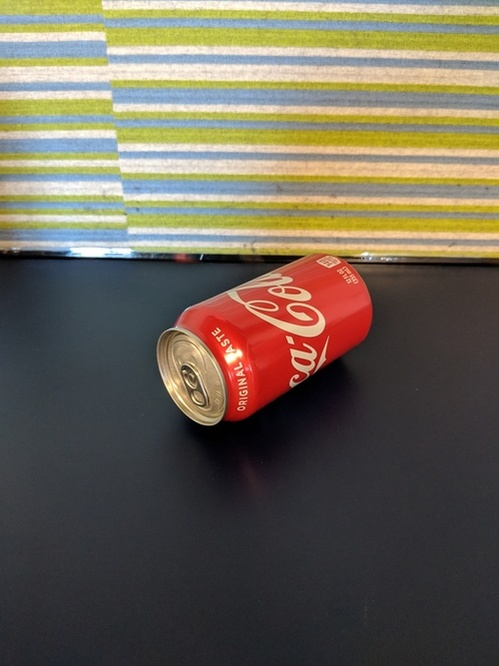

In [7]:
from IPython.display import Image

sample_image = os.path.join(dataset_dir, "images","99.jpg")
Image(filename=sample_image)

Prepare sample csv for batch endpoint inference.

In [9]:
import base64
import pandas as pd
import os

sample_image = os.path.join(dataset_dir, "images", "99.jpg")

def read_image(image_path):
    with open(image_path, "rb") as f:
        return f.read()

# Convert the image to base64 and prepare the data for DataFrame
image_base64 = base64.encodebytes(read_image(sample_image)).decode("utf-8")
data = [
    [image_base64, "[[[[280,320]], [[300,350]]]]", "", "", False],
    [image_base64, "[[[[280,320], [300,350]]]]", "", "", False],
    [image_base64, "", "[[[125,240,375,425]]]", "", False],
    [image_base64, "[[[[280,320]]]]", "[[[125,240,375,425]]]", "", False],
    [image_base64, "[[[[280,320]]]]", "[[[125,240,375,425]]]", "[[[0]]]", False]
]

# Create DataFrame
df = pd.DataFrame(data, columns=["image", "input_points", "input_boxes", "input_labels", "multimask_output"])

# Save DataFrame to CSV
batch_input_csv_file_path = "sample_request_data.csv"
df.to_csv(batch_input_csv_file_path, index=False)


### 4. Deploy the model to a batch endpoint
Batch endpoints are endpoints that are used to do batch inferencing on large volumes of data over a period of time. The endpoints receive pointers to data and run jobs asynchronously to process the data in parallel on compute clusters. Batch endpoints store outputs to a data store for further analysis. For more information on batch endpoints and deployments see [What are batch endpoints?](https://learn.microsoft.com/en-us/azure/machine-learning/concept-endpoints?view=azureml-api-2#what-are-batch-endpoints).

* Create a batch endpoint.
* Create a batch deployment.
* Set the deployment as default; doing so allows invoking the endpoint without specifying the deployment's name.

#### Create a batch endpoint

In [ ]:
import time
from azure.ai.ml.entities import (
    BatchEndpoint,
    BatchDeployment,
    BatchRetrySettings,
)

# Endpoint names need to be unique in a region, hence using timestamp to create unique endpoint name
timestamp = int(time.time())
endpoint_name = "mask-gen-" + str(timestamp)
# Create a batch endpoint
endpoint = BatchEndpoint(
    name=endpoint_name,
    description="Batch endpoint for "
    + foundation_model.name
    + ", for mask-generation task",
)
workspace_ml_client.begin_create_or_update(endpoint).result()

#### Create a batch deployment

In [ ]:
deployment_name = "mask-gen-demo"

deployment = BatchDeployment(
    name=deployment_name,
    endpoint_name=endpoint_name,
    model=foundation_model.id,
    compute=compute_name,
    error_threshold=0,
    instance_count=1,
    logging_level="info",
    max_concurrency_per_instance=1,
    mini_batch_size=2,
    output_file_name="predictions.csv",
    retry_settings=BatchRetrySettings(max_retries=3, timeout=600),
)
workspace_ml_client.begin_create_or_update(deployment).result()

#### Set the deployment as default

In [ ]:
endpoint = workspace_ml_client.batch_endpoints.get(endpoint_name)
endpoint.defaults.deployment_name = deployment_name
workspace_ml_client.begin_create_or_update(endpoint).result()

endpoint = workspace_ml_client.batch_endpoints.get(endpoint_name)
print(f"The default deployment is {endpoint.defaults.deployment_name}")

### 5. Test the endpoint - Using CSV input with base64 images from 3

Invoke the batch endpoint with the input parameter pointing to the csv file containing the batch inference input. This creates a pipeline job using the default deployment in the endpoint. Wait for the job to complete.

In [ ]:
job = None
input = Input(path=batch_input_csv_file_path, type=AssetTypes.URI_FILE)
num_retries = 3
for i in range(num_retries):
    try:
        job = workspace_ml_client.batch_endpoints.invoke(
            endpoint_name=endpoint.name, input=input
        )
        break
    except Exception as e:
        if i == num_retries - 1:
            raise e
        else:
            print("Endpoint invocation failed. Retrying after 5 seconds...")
            time.sleep(5)
if job is not None:
    workspace_ml_client.jobs.stream(job.name)

In [ ]:
scoring_job = list(workspace_ml_client.jobs.list(parent_job_name=job.name))[0]

workspace_ml_client.jobs.download(
    name=scoring_job.name,
    download_path=os.path.join(dataset_parent_dir, "csv-output"),
    output_name="score",
)

predictions_file = os.path.join(
    dataset_parent_dir, "csv-output", "named-outputs", "score", "predictions.csv"
)

# Load the batch predictions file with no headers into a dataframe and set your column names
score_df = pd.read_csv(
    predictions_file,
    header=None,
    names=["row_number_per_file", "preds", "labels", "file_name"],
)

### 6. Clean up resources - delete the endpoint
Batch endpoints use compute resources only when jobs are submitted. You can keep the batch endpoint for your reference without worrying about compute bills, or choose to delete the endpoint. If you created your compute cluster to have zero minimum instances and scale down soon after being idle, you won't be charged for an unused compute.

In [ ]:
workspace_ml_client.batch_endpoints.begin_delete(name=endpoint_name).result()